# UC15 Crop conditions - Indices calculations

This is the second part of the crop conditions calculation. In the "UC15-sen2like.ipynb", we computed the sen2like L2F product for a selected spatio-temporal extent for all the bands used in the indices calculation. We make use of the "load_stac" process, to reload the previously computed sen2like outputs. This is especially useful, when we compute multiple indices from the same sen2like outputs, as the sen2like processing only needs to be done once.

First, we create the connection to the openEO backend.

In [1]:
import openeo
from openeo.rest.datacube import THIS

conn = openeo.connect("openeo.cloud").authenticate_oidc()

Authenticated using refresh token.


We insert the url with the latest "job_id" into the "load_stac" process to load the results. 

The spatio-temporal extent can be the same as in the previous job. We select the bands "B03", "B04", "B05", "B06", "B07", "B8A", "B11", "B12", as these are required in the computation for the LAI. 

In [2]:
sen2like_job_id = "eodc-5d4c1746-33b2-42fb-914c-d36987747ae6"

spatial_extent = {"west": 16.6, "east": 16.7, "south": 47.9, "north": 48}
temporal_extent = ["2023-06-01", "2023-09-30"]
bands = ["B03", "B04", "B05", "B06", "B07", "B8A", "B11", "B12"]

data = conn.load_stac(
    url = f"https://openeo.eodc.eu/openeo/1.1.0/jobs/{sen2like_job_id}/results",
    spatial_extent=spatial_extent, 
    temporal_extent=temporal_extent, 
    bands=bands)

## LAI

The Leaf Area Index (LAI) process is based on the computation specified at https://custom-scripts.sentinel-hub.com/sentinel-2/lai/. To compute the LAI, the bands "B03", "B04", "B05", "B06", "B07", "B8A", "B11", "B12" need to be available, as well as the "viewZenithMean", "viewAzimuthMean", "sunZenithAngles", "sunAzimuthAngles". The sen2like output data includes these angles automatically.

In [3]:
lai = data.process('lai', {'data': data})

lai_nc = lai.save_result(format="NetCDF", options={"tile_grid":"time-series"})

We create and start the openEO job.

In [4]:
job = lai_nc.create_job().start_job()

In [5]:
job

<BatchJob job_id='eodc-2a99f1f0-5100-4c33-a6ba-f9c99c15c65d'>

Once the job status is "finished", we can download and explore the results. 

In [8]:
job.get_results().download_files("./lai/")

[PosixPath('lai/TimeSeries_E5286685N1583785_20230601T095722.nc'),
 PosixPath('lai/TimeSeries_E5286685N1588785_20230601T095722.nc'),
 PosixPath('lai/TimeSeries_E5290945N1583785_20230601T095722.nc'),
 PosixPath('lai/TimeSeries_E5286685N1592195_20230601T095722.nc'),
 PosixPath('lai/TimeSeries_E5290945N1592195_20230601T095722.nc'),
 PosixPath('lai/TimeSeries_E5290945N1588785_20230601T095722.nc'),
 PosixPath('lai/job-results.json')]

In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

path = "./lai/"
files = [path+file for file in os.listdir(path) if file.startswith("Time")]
lai = xr.open_mfdataset(files).name
lai = lai.where(lai!=-9999, np.nan)

In [10]:
lai

<xarray.DataArray 'name' (time: 25, y: 1183, x: 853)> Size: 101MB
dask.array<where, shape=(25, 1183, 853), dtype=float32, chunksize=(13, 251, 251), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 9kB 1.593e+06 1.593e+06 ... 1.581e+06 1.581e+06
  * x            (x) float64 7kB 5.284e+06 5.284e+06 ... 5.293e+06 5.293e+06
  * time         (time) datetime64[ns] 200B 2023-06-01T09:57:22.722646 ... 20...
    spatial_ref  int32 4B 0
Attributes:
    sen2like:  https://github.com/senbox-org/sen2like/
    nodata:    -9999
    crs:       PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["W...

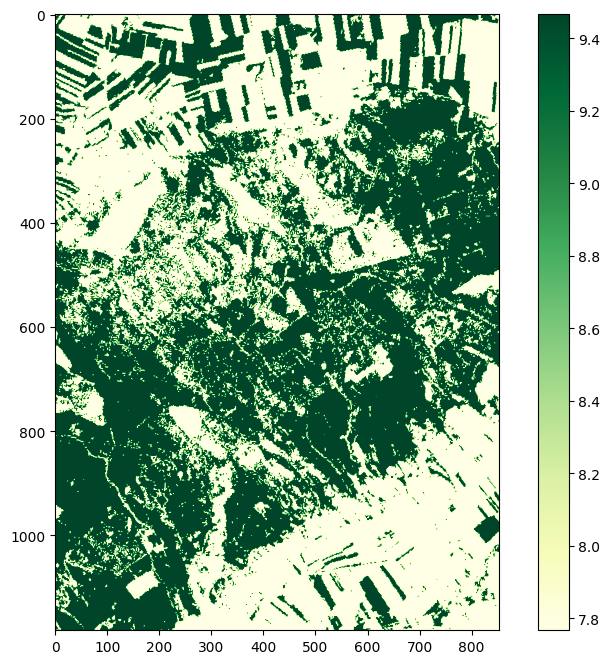

In [11]:
plt.figure(figsize=(10,8))
plt.imshow(lai[0], cmap="YlGn")
plt.colorbar()

### LAI on pre-computed sen2like results for a small spatial extent

| bands | spatial_extent | time | jobs | credits |
| --- | --- | --- | --- | --- |
| B03, B04, | west: 16.6 | ["2023-06-01T00:00:00Z", | LAI NetCDFs  | 3 credits |
| B05, B06, B07, | east: 16.7 |  "2023-09-30T00:00:00Z"] | from sen2like results: | --- |
| B8A, B11, B12 | south: 47.9 | --- | --- | --- |
| --- | north: 48 | --- | --- | --- |

## CAB

The same input data can be used to compute the Leaf Chlorophyll Content (CAB) in a seperate process graph. The processing is based on the computation from https://custom-scripts.sentinel-hub.com/sentinel-2/cab/.

In [6]:
cab = data.process('cab', {'data': data})

cab_nc = cab.save_result(format="NetCDF", options={"tile_grid":"time-series"})

In [7]:
job = cab_nc.create_job().start_job()

In [8]:
job

<BatchJob job_id='eodc-432b163d-0b89-421d-b116-effeda0a7565'>

In [18]:
job.get_results().download_files("./cab/")

[PosixPath('cab/TimeSeries_E5286685N1592195_20230601T095722.nc'),
 PosixPath('cab/TimeSeries_E5290945N1588785_20230601T095722.nc'),
 PosixPath('cab/TimeSeries_E5290945N1583785_20230601T095722.nc'),
 PosixPath('cab/TimeSeries_E5286685N1588785_20230601T095722.nc'),
 PosixPath('cab/TimeSeries_E5286685N1583785_20230601T095722.nc'),
 PosixPath('cab/TimeSeries_E5290945N1592195_20230601T095722.nc'),
 PosixPath('cab/job-results.json')]

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

path = "./cab/"
files = [path+file for file in os.listdir(path) if file.startswith("Time")]
cab = xr.open_mfdataset(files).name
cab = cab.where(cab!=-9999, np.nan)

In [8]:
cab

<xarray.DataArray 'name' (time: 25, y: 1183, x: 853)> Size: 101MB
dask.array<where, shape=(25, 1183, 853), dtype=float32, chunksize=(13, 251, 251), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 9kB 1.593e+06 1.593e+06 ... 1.581e+06 1.581e+06
  * x            (x) float64 7kB 5.284e+06 5.284e+06 ... 5.293e+06 5.293e+06
  * time         (time) datetime64[ns] 200B 2023-06-01T09:57:22.722646 ... 20...
    spatial_ref  int32 4B 0
Attributes:
    sen2like:  https://github.com/senbox-org/sen2like/
    nodata:    -9999
    crs:       PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["W...

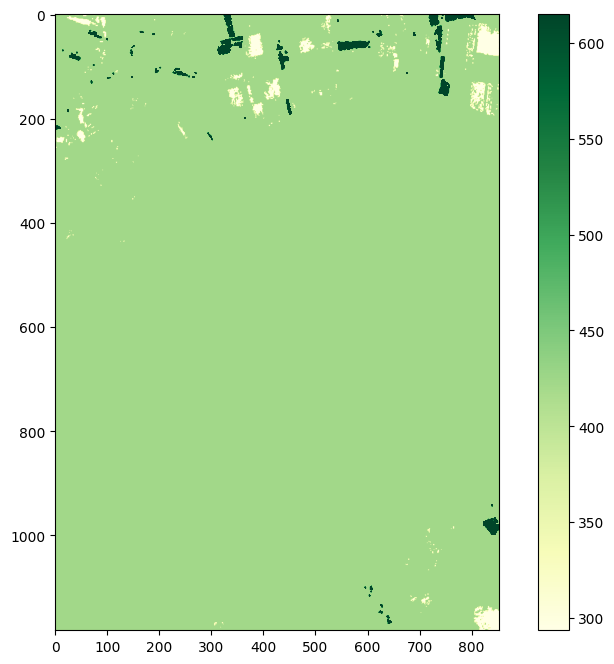

In [10]:
plt.figure(figsize=(10,8))
plt.imshow(cab[0], cmap="YlGn", vmax=615)
plt.colorbar()

### CAB on pre-computed sen2like results for a small spatial extent

| bands | spatial_extent | time | jobs | credits |
| --- | --- | --- | --- | --- |
| B03, B04, | west: 16.6 | ["2023-06-01T00:00:00Z", | CAB NetCDFs  | 2 credits |
| B05, B06, B07, | east: 16.7 |  "2023-09-30T00:00:00Z"] | from sen2like results: | --- |
| B8A, B11, B12 | south: 47.9 | --- | --- | --- |
| --- | north: 48 | --- | --- | --- |

## FCOVER

In the same manner, we compute the Fraction of green Vegetation Cover (FCOVER), which is based on the calculations from https://custom-scripts.sentinel-hub.com/sentinel-2/fcover/.

In [6]:
fcover = data.process('fcover', {'data': data})

fcover_nc = fcover.save_result(format="NetCDF", options={"tile_grid":"time-series"})

In [7]:
job = fcover_nc.create_job().start_job()

In [31]:
job

<BatchJob job_id='63d729b4-5336-47c6-9187-d4da758751ae'>

In [32]:
job.get_results().download_files("./fcover/")

[PosixPath('fcover/TimeSeries_E5286685N1583785_20230601T095722.nc'),
 PosixPath('fcover/TimeSeries_E5286685N1588785_20230601T095722.nc'),
 PosixPath('fcover/TimeSeries_E5290945N1583785_20230601T095722.nc'),
 PosixPath('fcover/TimeSeries_E5286685N1592195_20230601T095722.nc'),
 PosixPath('fcover/TimeSeries_E5290945N1592195_20230601T095722.nc'),
 PosixPath('fcover/TimeSeries_E5290945N1588785_20230601T095722.nc'),
 PosixPath('fcover/job-results.json')]

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

path = "./fcover/"
files = [path+file for file in os.listdir(path) if file.startswith("Time")]
fcover = xr.open_mfdataset(files).name
fcover = fcover.where(fcover!=-9999, np.nan)

In [12]:
fcover

<xarray.DataArray 'name' (time: 25, y: 1183, x: 853)> Size: 101MB
dask.array<where, shape=(25, 1183, 853), dtype=float32, chunksize=(13, 251, 251), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 9kB 1.593e+06 1.593e+06 ... 1.581e+06 1.581e+06
  * x            (x) float64 7kB 5.284e+06 5.284e+06 ... 5.293e+06 5.293e+06
  * time         (time) datetime64[ns] 200B 2023-06-01T09:57:22.722646 ... 20...
    spatial_ref  int32 4B 0
Attributes:
    sen2like:  https://github.com/senbox-org/sen2like/
    nodata:    -9999
    crs:       PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["W...

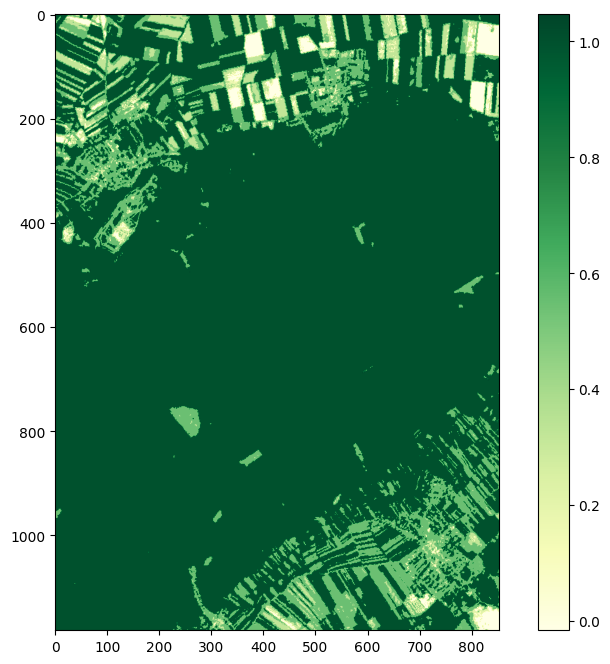

In [13]:
plt.figure(figsize=(10,8))
plt.imshow(fcover[0], cmap="YlGn")
plt.colorbar()

## FAPAR

The Fraction of Absorbed Photosynthetically Active Radiation (FAPAR) computation can be found at https://custom-scripts.sentinel-hub.com/sentinel-2/fapar/.

In [11]:
fapar = data.process('fapar', {'data': data})

fapar_nc = fapar.save_result(format="NetCDF", options={"tile_grid":"time-series"})

In [12]:
job = fapar_nc.create_job().start_job()

In [37]:
job

<BatchJob job_id='74900ed5-3861-4f71-9384-f09bee0e1e55'>

In [38]:
job.get_results().download_files("./fapar/")

[PosixPath('fapar/TimeSeries_E5286685N1588785_20230601T095722.nc'),
 PosixPath('fapar/TimeSeries_E5286685N1592195_20230601T095722.nc'),
 PosixPath('fapar/TimeSeries_E5286685N1583785_20230601T095722.nc'),
 PosixPath('fapar/TimeSeries_E5290945N1583785_20230601T095722.nc'),
 PosixPath('fapar/TimeSeries_E5290945N1592195_20230601T095722.nc'),
 PosixPath('fapar/TimeSeries_E5290945N1588785_20230601T095722.nc'),
 PosixPath('fapar/job-results.json')]

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

path = "./fapar/"
files = [path+file for file in os.listdir(path) if file.startswith("Time")]
fapar = xr.open_mfdataset(files).name
fapar = fapar.where(fapar!=-9999, np.nan)

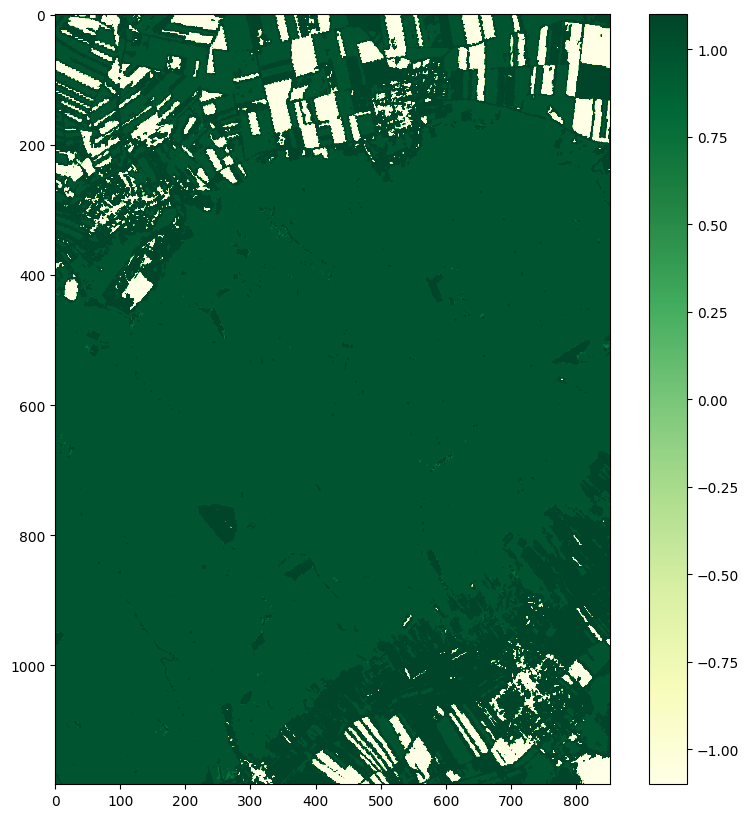

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(fapar[0], cmap="YlGn", vmin=-1.1, vmax=1.1)
plt.colorbar()

In [16]:
fapar[0,:5,:5].values

array([[0.9780712, 0.9780712, 0.9780712, 0.9780712, 0.9780712],
       [1.333854 , 1.333854 , 0.9780712, 0.9780712, 0.9780712],
       [1.333854 , 0.9780712, 0.9780712, 0.9780712, 0.9780712],
       [1.333854 , 0.9780712, 0.9780712, 0.9780712, 0.9780712],
       [1.333854 , 0.9780712, 0.9780712, 0.9780712, 0.9780712]],
      dtype=float32)

Alternatively, these indices can be generated using the webeditor UDP wizard functionality. The list of UDPs includes a "sen2like_cab", "sen2like_lai" etc.

<img src="../udp-2.png" width="1000"/>

Selecting one of the UDPs first, the only other specification to be made are the spatial and temporal extent. The results will then contain the selected index. These UDPs include both the sen2like processing and the index computation on top of it. To give an example, the LAI can be found under https://editor.openeo.org/?server=https%3A%2F%2Fopeneo.eodc.eu%2Fopeneo%2F1.1.0&wizard=UDP&wizard%7Eprocess=sen2like_lai

<img src="../udp-3.png" width="1000"/>

Finally, when the processing is finished, the results will also include information about the cost of the individual job runs. 

The job information will include a section about Billing: 

<img src="../udp-4.png" width="1000"/>

### sen2like LAI on small scale

| bands | spatial_extent | time | jobs | credits |
| --- | --- | --- | --- | --- |
| B03, B04, | west: 16.1 | ["2023-06-01T00:00:00Z", | Running sen2like  | 28 credits |
| B05, B06, B07, | east: 16.15 |  "2023-06-20T00:00:00Z"] | producing LAI NetCDF: | --- |
| B8A, B11, B12 | south: 48.25 | --- | --- | --- |
| --- | north: 48.3 | --- | --- | --- |

Note, that we can save a lot of credits by running sen2like once and then reusing the results to compute indices for smaller spatial extents. 

## NDVI

The computation of the indices could also be done in one process graph with the sen2like processing. In this case, we start with the "load_collection" process and select the bands "B04" and "B08".

In [26]:
spatial_extent =  {"west": 16.0, "east": 16.1, "south": 48.4, "north": 48.5}
temporal_extent = ["2023-06-01", "2023-09-30"]

collection      = 'SENTINEL2_L1C'
bands = ["B04", "B08"]

S2 = conn.load_collection(
    collection, 
    spatial_extent=spatial_extent, 
    temporal_extent=temporal_extent, 
    bands=bands)

We compute the sen2like "L2F" product.

In [27]:
sen2like = S2.process('sen2like', {
    'data': THIS,
    'target_product': 'L2F', 
    'export_original_files': True,
    'cloud_cover': 50})

We make use of the "ndvi" process and select a format and options for saving.

In [28]:
ndvi = sen2like.ndvi(nir="B08", red="B04")

ndvi_nc = ndvi.save_result(format="NetCDF", options={"tile_grid":"time-series"})

ndvi_nc

In [29]:
job = ndvi_nc.create_job().start_job()

In [10]:
job

<BatchJob job_id='2e30ac61-0087-4c8b-927a-0604b8ce9b63'>

### Computing only B04, B08 

| bands | spatial_extent | time | jobs | credits |
| --- | --- | --- | --- | --- |
| B04, B08 | west: 16.0 | ["2023-06-01T00:00:00Z", | Producing sen2like  | 80 credits |
| --- | east: 16.1 |  "2023-09-30T00:00:00Z"] | original .SAFE files | --- |
| --- | south: 48.4 | --- | and compute NDVI | --- |
| --- | north: 48.5 | --- | --- | --- |

Wall time: 163 minutes

In [46]:
job.get_results().download_files("./ndvi/")

[PosixPath('ndvi/S2A_MSIL2F_20230815T095031_N0404_R079_T33UWP_20240527T101233.SAFE'),
 PosixPath('ndvi/S2A_MSIL2F_20230629T100031_N0404_R122_T33UWP_20240527T093727.SAFE'),
 PosixPath('ndvi/S2B_MSIL2F_20230717T100559_N0404_R022_T33UWP_20240527T095620.SAFE'),
 PosixPath('ndvi/LS8_OLIL2F_20230716T094454_N0404_R190_T33UWP_20240527T095446.SAFE'),
 PosixPath('ndvi/S2A_MSIL2F_20230818T100031_N0404_R122_T33UWP_20240527T101427.SAFE'),
 PosixPath('ndvi/S2A_MSIL2F_20230917T100031_N0404_R122_T33UWP_20240527T104235.SAFE'),
 PosixPath('ndvi/S2A_MSIL2F_20230920T100711_N0404_R022_T33UWP_20240527T104610.SAFE'),
 PosixPath('ndvi/S2A_MSIL2F_20230904T095031_N0404_R079_T33UWP_20240527T102840.SAFE'),
 PosixPath('ndvi/LS9_OLIL2F_20230724T094447_N0404_R190_T33UWP_20240527T100036.SAFE'),
 PosixPath('ndvi/LS9_OLIL2F_20230622T094432_N0404_R190_T33UWP_20240527T093347.SAFE'),
 PosixPath('ndvi/LS9_OLIL2F_20230825T094505_N0404_R190_T33UWP_20240527T102145.SAFE'),
 PosixPath('ndvi/S2B_MSIL2F_20230707T100559_N0404_R022

In [47]:
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

path = "./ndvi/"
files = [path+file for file in os.listdir(path) if file.endswith(".nc")]
ndvi = xr.open_mfdataset(files).name
ndvi = ndvi.where(ndvi!=-9999, np.nan)

In [48]:
ndvi

<xarray.DataArray 'name' (time: 51, y: 1188, x: 854)> Size: 207MB
dask.array<concatenate, shape=(51, 1188, 854), dtype=float32, chunksize=(26, 251, 251), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 10kB 1.653e+06 1.653e+06 ... 1.641e+06 1.641e+06
  * x            (x) float64 7kB 5.245e+06 5.245e+06 ... 5.254e+06 5.254e+06
  * time         (time) datetime64[ns] 408B 2023-06-01T09:57:25.756257 ... 20...
    spatial_ref  int32 4B 0
Attributes:
    sen2like:  https://github.com/senbox-org/sen2like/
    nodata:    -9999
    crs:       PROJCS["unknown",GEOGCS["unknown",DATUM["WGS_1984",SPHEROID["W...

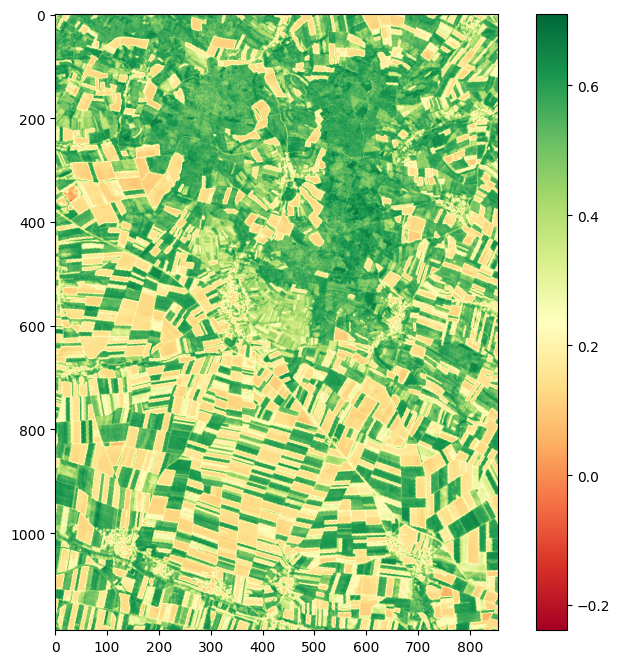

In [54]:
plt.figure(figsize=(10,8))
plt.imshow(ndvi[0], cmap="RdYlGn")
plt.colorbar()

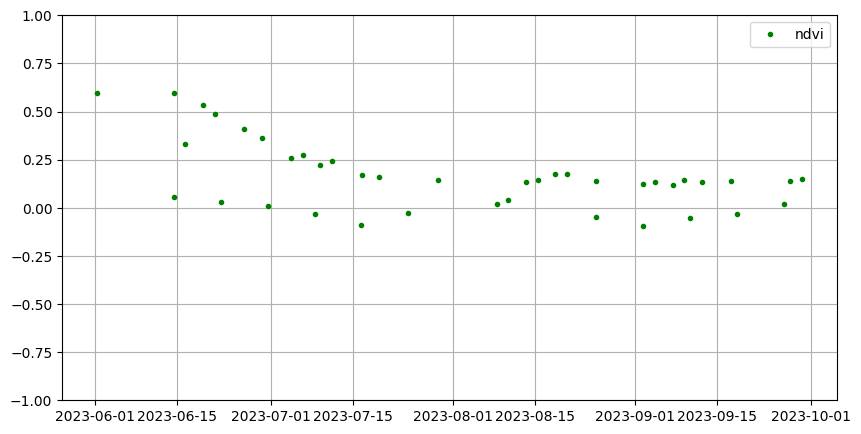

In [62]:
plt.figure(figsize=(10,5))
plt.plot(ndvi["time"].values, ndvi[:,40,10], ".", c="g", label="ndvi")
plt.ylim(-1, 1)
plt.legend()
plt.grid()

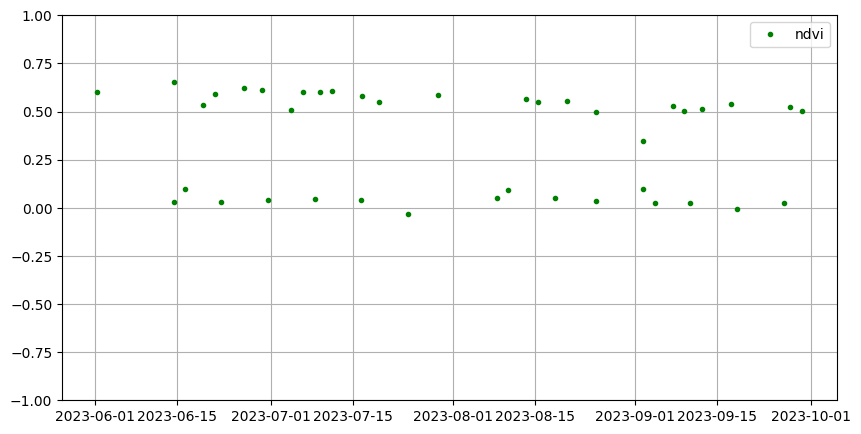

In [67]:
plt.figure(figsize=(10,5))
plt.plot(ndvi["time"].values, ndvi[:,200,250], ".", c="g", label="ndvi")
plt.ylim(-1, 1)
plt.legend()
plt.grid()